## Discrete-Time Black Scholes
Welcome to your notebook on Reinforcement Learning in Finance. This exercise will introduce Black-Scholes model as viewed through the lens of pricing an option as discrete-time replicating portfolio of stock and bond.

**Instructions:**
- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.

Let's get started!

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import standard_normal, seed

import scipy.stats as stats
from scipy.stats import norm

import sys
import datetime 
import time


In [11]:
!pip install yfinance
import bspline
import bspline.splinelab as spline
import yfinance as yf

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=1f7198cfd59cfd303d70e1eb5cb90456e66d9aa0a546386758a73f3644bc0823
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
# The Black-Scholes prices
def bs_put(t, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

def d1(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
 
def d2(S0, K, r, sigma, T):
    return (np.log(S0 / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
 

Simulate $N_{MC}$ stock price sample paths with $T$ steps by the classical Black-Sholes formula.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

where $Z$ is a standard normal random variable.

MC paths are simulated by GeneratePaths() method of DiscreteBlackScholes class.

### Part 1


Class DiscreteBlackScholes implements the above calculations with class variables to math symbols mapping of:

$$\Delta S_t=S_{t+1} - e^{-r\Delta t} S_t\space \quad t=T-1,...,0$$
 
**Instructions:**
Some portions of code in DiscreteBlackScholes have bee taken out. You are to implement the missing portions of code in DiscreteBlackScholes class.

$$\Pi_t=e^{-r\Delta t}\left[\Pi_{t+1}-u_t \Delta S_t\right]\quad t=T-1,...,0$$

- implement DiscreteBlackScholes.function_A_vec() method
$$A_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)\left(\Delta\hat{S}_t^k\right)^2}\quad\quad$$ 

- implement DiscreteBlackScholes.function_B_vec() method
$$B_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left[\hat\Pi_{t+1}^k\Delta\hat{S}_t^k+\frac{1}{2\gamma\lambda}\Delta S_t^k\right]}$$
- implement DiscreteBlackScholes.gen_paths() method using the following relation:
$$S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$
where $Z \sim N(0,1)$
- implement parts of DiscreteBlackScholes.roll_backward()
    - DiscreteBlackScholes.bVals corresponds to $B_t$ and is computed as $$B_t = e^{-r\Delta t}\left[B_{t+1} + (u_{t+1} - u_t)S_{t+1}\right]\quad t=T-1,...,0$$
    
DiscreteBlackScholes.opt_hedge corresponds to $\phi_t$ and is computed as 
     $$\phi_t=\mathbf A_t^{-1}\mathbf B_t$$

In [0]:
class DiscreteBlackScholes:
    """
    Class implementing discrete Black Scholes
    DiscreteBlackScholes is class for pricing and hedging under
    the real-world measure for a one-dimensional Black-Scholes setting
    """

    def __init__(self,
                 s0,
                 strike,
                 vol,
                 T,
                 r,
                 mu,
                 numSteps,
                 numPaths):
        """
        :param s0: initial price of the underlying
        :param strike: option strike
        :param vol: volatility
        :param T: time to maturity, in years
        :param r: risk-free rate,
        :param mu: real drift, asset drift
        :param numSteps: number of time steps
        :param numPaths: number of Monte Carlo paths
        """
        self.s0 = s0
        self.strike = strike
        self.vol = vol
        self.T = T
        self.r = r
        self.mu = mu
        self.numSteps = numSteps
        self.numPaths = numPaths

        self.dt = self.T / self.numSteps  # time step
        self.gamma = np.exp(-r * self.dt)  # discount factor for one time step, i.e. gamma in the QLBS paper

        self.sVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # matrix of stock values

        # initialize half of the paths with stock price values ranging from 0.5 to 1.5 of s0
        # the other half of the paths start with s0
        half_paths = int(numPaths / 2)

        if False:
            # Grau (2010) "Applications of Least-Squares Regressions to Pricing and Hedging of Financial Derivatives"
            self.sVals[:, 0] = (np.hstack((np.linspace(0.5 * s0, 1.5 * s0, half_paths),
                                           s0 * np.ones(half_paths, 'float')))).T

        self.sVals[:, 0] = s0 * np.ones(numPaths, 'float')
        self.optionVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # matrix of option values
        self.intrinsicVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')

        self.bVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # matrix of cash position values
        self.opt_hedge = np.zeros((self.numPaths, self.numSteps + 1),
                              'float')  # matrix of optimal hedges calculated from cross-sectional information F_t
        self.X = None
        self.data = None  # matrix of features, i.e. self.X as sum of basis functions
        self.delta_S_hat = None

        # coef = 1.0/(2 * gamma * risk_lambda)
        # override it by zero to have pure risk hedge
        self.coef = 0.

    def gen_paths(self):
        """
        A simplest path generator
        """
        np.random.seed(42)
        # Spline basis of order p on knots k

        Z = np.random.normal(0, 1, size=(self.numSteps + 1, self.numPaths)).T
        for t in range(0, self.numSteps):
            self.sVals[:, t + 1] = self.sVals[:, t] * np.exp((self.mu - 0.5 * self.vol**2) * self.dt + (self.vol * np.sqrt(self.dt) * Z[:, t + 1]))
        
        print(self.sVals)

        # like in QLBS
        delta_S = self.sVals[:, 1:] - np.exp(self.r * self.dt) * self.sVals[:, :self.numSteps]
        self.delta_S_hat = np.apply_along_axis(lambda x: x - np.mean(x), axis=0, arr=delta_S)

        # state variable
        # delta_t here is due to their conventions
        self.X = - (self.mu - 0.5 * self.vol ** 2) * np.arange(self.numSteps + 1) * self.dt + np.log(self.sVals)

        X_min = np.min(np.min(self.X))
        X_max = np.max(np.max(self.X))

        print('X.shape = ', self.X.shape)
        print('X_min, X_max = ', X_min, X_max)

        p = 4  # order of spline (as-is; 3 = cubic, 4: B-spline?)
        ncolloc = 12
        tau = np.linspace(X_min, X_max, ncolloc)  # These are the sites to which we would like to interpolate

        # k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
        # To get meaningful results, one should have ncolloc >= p+1
        #k = splinelab.aptknt(tau, p)
        k = spline.aptknt(tau, p)
        basis = bspline.Bspline(k, p)

        num_basis = ncolloc  # len(k) #
        self.data = np.zeros((self.numSteps + 1, self.numPaths, num_basis))

        print('num_basis = ', num_basis)
        print('dim self.data = ', self.data.shape)

        # fill it, expand function in finite dimensional space
        # in neural network the basis is the neural network itself
        t_0 = time.time()
        for ix in np.arange(self.numSteps + 1):
            x = self.X[:, ix]
            self.data[ix, :, :] = np.array([basis(el) for el in x])
        t_end = time.time()
        print('\nTime Cost of basis expansion:', t_end - t_0, 'seconds')

    def function_A_vec(self, t, reg_param=1e-3):
        """
        function_A_vec - compute the matrix A_{nm} from Eq. (52) (with a regularization!)
        Eq. (52) in QLBS Q-Learner in the Black-Scholes-Merton article

        Arguments:
        t - time index, a scalar, an index into time axis of data_mat
        reg_param - a scalar, regularization parameter

        Return:
        - np.array, i.e. matrix A_{nm} of dimension num_basis x num_basis
        """
        X_mat = self.data[t, :, :]
        num_basis_funcs = X_mat.shape[1]
        this_dS = self.delta_S_hat[:, t]
        hat_dS2 = (this_dS ** 2).reshape(-1, 1)
        A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
        return A_mat

    def function_B_vec(self, t, Pi_hat):
        """
        function_B_vec - compute vector B_{n} from Eq. (52) QLBS Q-Learner in the Black-Scholes-Merton article

        Arguments:
        t - time index, a scalar, an index into time axis of delta_S_hat
        Pi_hat - pandas.DataFrame of dimension N_MC x T of portfolio values
        Return:
        B_vec - np.array() of dimension num_basis x 1
        """
        tmp = Pi_hat * self.delta_S_hat[:, t] + self.coef * (np.exp((self.mu - self.r) * self.dt)) * self.sVals[:, t]
        X_mat = self.data[t, :, :]  # matrix of dimension N_MC x num_basis

        B_vec = np.dot(X_mat.T, tmp)
        return B_vec

    def seed_intrinsic(self, strike=None, cp='P'):
        """
        initilaize option value and intrinsic value for each node
        """
        if strike is not None:
            self.strike = strike

        if cp == 'P':
            # payoff function at maturity T: max(K - S(T),0) for all paths
            self.optionVals = np.maximum(self.strike - self.sVals[:, -1], 0).copy()
            # payoff function for all paths, at all time slices
            self.intrinsicVals = np.maximum(self.strike - self.sVals, 0).copy()
        elif cp == 'C':
            # payoff function at maturity T: max(S(T) -K,0) for all paths
            self.optionVals = np.maximum(self.sVals[:, -1] - self.strike, 0).copy()
            # payoff function for all paths, at all time slices
            self.intrinsicVals = np.maximum(self.sVals - self.strike, 0).copy()
        else:
            raise Exception('Invalid parameter: %s'% cp)

        self.bVals[:, -1] = self.intrinsicVals[:, -1]

    def roll_backward(self):
        """
        Roll the price and optimal hedge back in time starting from maturity
        """

        for t in range(self.numSteps - 1, -1, -1):

            # determine the expected portfolio value at the next time node
            piNext = self.bVals[:, t+1] + self.opt_hedge[:, t+1] * self.sVals[:, t+1]
            pi_hat = piNext - np.mean(piNext)

            A_mat = self.function_A_vec(t)
            B_vec = self.function_B_vec(t, pi_hat)
            phi = np.dot(np.linalg.inv(A_mat), B_vec)
            self.opt_hedge[:, t] = np.dot(self.data[t, :, :], phi)
            self.bVals[:,t] = np.exp(-self.r * self.dt) * (self.bVals[:, t+1] + (self.opt_hedge[:, t+1] - self.opt_hedge[:, t]) * self.sVals[:, t+1])


        # calculate the initial portfolio value
        initPortfolioVal = self.bVals[:, 0] + self.opt_hedge[:, 0] * self.sVals[:, 0]

        # use only the second half of the paths generated with paths starting from S0
        optionVal = np.mean(initPortfolioVal)
        optionValVar = np.std(initPortfolioVal)
        delta = np.mean(self.opt_hedge[:, 0])

        return optionVal, delta, optionValVar

# Start Here after running above. --- ^^^^everything above is function setup^^^^ ---

4.027770813919196e-06
0.37273678070971333
0.03276969400915947
[[100.         103.32524422 101.68530252 ... 174.17600532 181.72446318
  173.4096136 ]
 [100.         102.1799176  101.81894704 ... 108.48366409 106.12036984
  107.08517384]
 [100.         100.12552992  98.26548928 ... 104.35638904 104.73786183
  106.30268703]
 ...
 [100.          97.93636805  95.10823333 ...  78.78703585  77.44310503
   76.69760445]
 [100.          99.60334195 100.37333944 ... 119.74269396 118.55089109
  117.288485  ]
 [100.          98.25185134  97.88007031 ...  73.80590585  76.81099416
   77.32621943]]
X.shape =  (1000, 253)
X_min, X_max =  3.384177655882019 5.748109864727805
num_basis =  12
dim self.data =  (253, 1000, 12)

Time Cost of basis expansion: 33.361369609832764 seconds


Text(0, 0.5, '$\\Pi_0$')

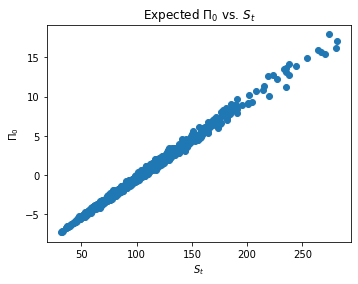

In [16]:
# Get real data


symbol='BA'
asset_df = yf.download(symbol, 
                      start='2014-05-01', 
                      end='2020-05-03', 
                      progress=False)

assetCls=asset_df['Adj Close']

asset_df['Log_Ret'] = np.log(asset_df['Close'] / asset_df['Close'].shift(1))
assetRets=asset_df['Log_Ret'].to_numpy()

assetRets=assetRets[1:,]
assetRets=assetCls.pct_change()/100
assetRets=assetRets[1:]

print(np.mean(assetRets))

num_paths = 1000
num_periods = 252


def random_sample(data=None, timesteps=100, batch_size=100):
    lenDat=data.shape[0]
    ret_data = np.empty((batch_size,timesteps))

    for i in range(0,batch_size):
        start_idx = np.random.randint(0, lenDat-timesteps-1)
        d = data[start_idx:start_idx+timesteps]
        ret_data[i,0:]=d
    return ret_data

retsMatrix=random_sample(assetRets,num_periods,num_paths)

test_vol=asset_df['Log_Ret'].std() * np.sqrt(252)
test_mu=np.log(assetCls[-1]/assetCls[0])/(assetCls.shape[0]/252)
print(test_vol)
print(test_mu)

# pick paths for real option fit


# Get data for simulated result
np.random.seed(42)
strike_k = 95
#test_vol = 0.2
#test_mu = 0.03
dt = 0.01
rfr = 0.05


# get RL option values using simulated data
hMC = DiscreteBlackScholes(100, strike_k, test_vol, 1., rfr, test_mu, num_periods, num_paths)
hMC.gen_paths()


t = hMC.numSteps - 1
piNext = hMC.bVals[:, t+1] + 0.1 * hMC.sVals[:, t+1]
pi_hat = piNext - np.mean(piNext)

A_mat = hMC.function_A_vec(t)
B_vec = hMC.function_B_vec(t, pi_hat)
phi = np.dot(np.linalg.inv(A_mat), B_vec)
opt_hedge = np.dot(hMC.data[t, :, :], phi)

# plot the results
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)

ax1.scatter(hMC.sVals[:,t], pi_hat)
ax1.set_title(r'Expected $\Pi_0$ vs. $S_t$')
ax1.set_xlabel(r'$S_t$')
ax1.set_ylabel(r'$\Pi_0$')


    


In [23]:
# input parameters
s0 = 100.0
strike = 100.0
r = 0.05
mu = test_mu # 0.05
vol = test_vol
T = 1.0

# Simulation Parameters
numPaths = 5000  # number of Monte Carlo trials
numSteps = 6

# create the class object
hMC = DiscreteBlackScholes(s0, strike, vol, T, r, mu, numSteps, numPaths)

# calculation
hMC.gen_paths()
hMC.seed_intrinsic()
option_val, delta, option_val_variance = hMC.roll_backward()
bs_call_value = bs_put(0, s0, K=strike, r=r, sigma=vol, T=T)
print('Option value = ', option_val)
print('Option value variance = ', option_val_variance)
print('Option delta = ', delta)  
print('BS value', bs_call_value)

[[100.          93.1835239   83.53025029 ...  85.1275278   86.8372806
   63.85008794]
 [100.          92.76398158  88.0103772  ...  90.32067564  89.93751837
   76.13155312]
 [100.          75.62694042  68.63437442 ...  59.37276023  55.26340457
   50.23274988]
 ...
 [100.          89.27545831 108.34148065 ... 131.35397395 120.96327901
  106.09986621]
 [100.         107.17835368  93.11581622 ... 131.27115512  97.82602288
   79.49002343]
 [100.         109.62989715 106.44119288 ...  82.37072537  79.0661523
   71.01586301]]
X.shape =  (5000, 7)
X_min, X_max =  3.232426101688083 6.10203650861775
num_basis =  12
dim self.data =  (7, 5000, 12)

Time Cost of basis expansion: 4.264025688171387 seconds
Option value =  12.224542267977846
Option value variance =  4.998610552593175
Option delta =  -0.3575407841459484
BS value 12.113414354854001


In [24]:
strikes = np.linspace(85, 110, 6)
results = [None] * len(strikes)
bs_prices = np.zeros(len(strikes))
bs_deltas = np.zeros(len(strikes))
numPaths = 5000
hMC = DiscreteBlackScholes(s0, strike, vol, T, r, mu, numSteps, numPaths)
hMC.gen_paths()
for ix, k_strike in enumerate(strikes):
    hMC.seed_intrinsic(k_strike)
    results[ix] = hMC.roll_backward()
    bs_prices[ix] = bs_put(0, s0, K=k_strike, r=r, sigma=vol, T=T)
    bs_deltas[ix] = norm.cdf(d1(s0, K=k_strike, r=r, sigma=vol, T=T)) - 1
bs_prices

[[100.          93.1835239   83.53025029 ...  85.1275278   86.8372806
   63.85008794]
 [100.          92.76398158  88.0103772  ...  90.32067564  89.93751837
   76.13155312]
 [100.          75.62694042  68.63437442 ...  59.37276023  55.26340457
   50.23274988]
 ...
 [100.          89.27545831 108.34148065 ... 131.35397395 120.96327901
  106.09986621]
 [100.         107.17835368  93.11581622 ... 131.27115512  97.82602288
   79.49002343]
 [100.         109.62989715 106.44119288 ...  82.37072537  79.0661523
   71.01586301]]
X.shape =  (5000, 7)
X_min, X_max =  3.232426101688083 6.10203650861775
num_basis =  12
dim self.data =  (7, 5000, 12)

Time Cost of basis expansion: 4.239112138748169 seconds


array([ 5.87825284,  7.6844941 ,  9.76566015, 12.11341435, 14.71509588,
       17.55499572])

In [25]:
mc_prices = np.array([x[0] for x in results])
mc_deltas = np.array([x[1] for x in results])
price_variances = np.array([x[-1] for x in results])
prices_diff = mc_prices - bs_prices
deltas_diff = mc_deltas - bs_deltas
price_variances

array([4.00965856, 4.40024443, 4.73864534, 4.99861055, 5.19890273,
       5.36992181])

In [26]:
prices_diff


array([-0.00266463,  0.02723668,  0.0607484 ,  0.11112791,  0.16129599,
        0.18676325])

In [27]:
deltas_diff


array([0.01306996, 0.01445299, 0.01524015, 0.01674959, 0.01887535,
       0.02055147])